# Portfolio/Multi-Stock RL Training and Evaluation

This notebook demonstrates how to train and evaluate a reinforcement learning (RL) agent on a **portfolio of multiple stocks** using a custom `TradingEnv` environment.  
Unlike single-stock trading, portfolio RL enables the agent to learn allocation and trading strategies across several assets simultaneously, considering both individual stock dynamics and overall portfolio performance.

**Key features of this notebook:**
- Loads and aligns historical price and sentiment data for all portfolio stocks.
- Trains a PPO (Proximal Policy Optimization) agent to maximize portfolio returns while accounting for transaction costs and sentiment signals.
- Evaluates the trained agent on unseen test data, tracking portfolio net worth, actions, and rewards.
- Visualizes results and compares RL performance to an equal-weighted buy-and-hold benchmark.

> _This notebook is adapted from a single-stock RL workflow and extended for multi-asset/portfolio trading._

In [1]:
import sys
sys.path.append('..')
import config

In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from config import TICKERS, TRAIN_START_DATE, TRAIN_END_DATE, TEST_START_DATE, TEST_END_DATE
from scripts.generic import load_test_model_env,plot_networths_profit, plot_one_instance,evaluate_model
from envs.trading_env import TradingEnv

print(torch.cuda.is_available())  # Should print True if CUDA is available

# Change the model and policy as needed

# from stable_baselines3 import PPO as MODEL
# POLICY = 'MlpPolicy'

from sb3_contrib import RecurrentPPO as MODEL 
POLICY = 'MlpLstmPolicy'

True


## Environment Creation (Portfolio Mode)

We'll use a custom Gymnasium environment that simulates trading a portfolio of stocks.

In [3]:
tickers = config.LEXCX_PORTFOLIO  # Portfolio tickers from config
env = TradingEnv(
    tickers=tickers,
    window_size=20,
    transaction_cost=0.01,
    stability_penalty_weight=0.1,
    sentiment_influence=0.2,
    mode='train',
    train_start_date=TRAIN_START_DATE,
    train_end_date=TRAIN_END_DATE,
    test_start_date=TEST_START_DATE,
    test_end_date=TEST_END_DATE
)
env = DummyVecEnv([lambda: env])
# env = VecNormalize(env,norm_obs=True,norm_reward=True,clip_obs=10.)

Data split complete for 21 stocks
Data aligned to 250 common trading days


## Model Training

Train a PPO agent on the portfolio environment.

In [4]:
# Create and train the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MODEL(POLICY, env, tensorboard_log="../logs",device=device ,verbose=1)

model.learn(total_timesteps=20000)

# Save the model
model_path = f"../models/{MODEL.__name__}_{tickers}.zip"
model.save(model_path)
env.envs[0].save(f"../models/env_{MODEL.__name__}_portfolio_lexcx.pkl")    

Using cuda device
Logging to ../logs\RecurrentPPO_30
----------------------------
| time/              |     |
|    fps             | 48  |
|    iterations      | 1   |
|    time_elapsed    | 2   |
|    total_timesteps | 128 |
----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 35         |
|    iterations           | 2          |
|    time_elapsed         | 7          |
|    total_timesteps      | 256        |
| train/                  |            |
|    approx_kl            | 0.03653314 |
|    clip_fraction        | 0.296      |
|    clip_range           | 0.2        |
|    entropy_loss         | -59.6      |
|    explained_variance   | -9.88      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0889    |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0885    |
|    std                  | 1          |
|    value_loss           | 0.14       |
------

## Model Evaluation

Evaluate the trained model on the test dataset. Track overall portfolio net worth, actions, and rewards.

Data split complete for 21 stocks
Data aligned to 400 common trading days
Data aligned to 251 common trading days
Environment set to test mode with 251 data points


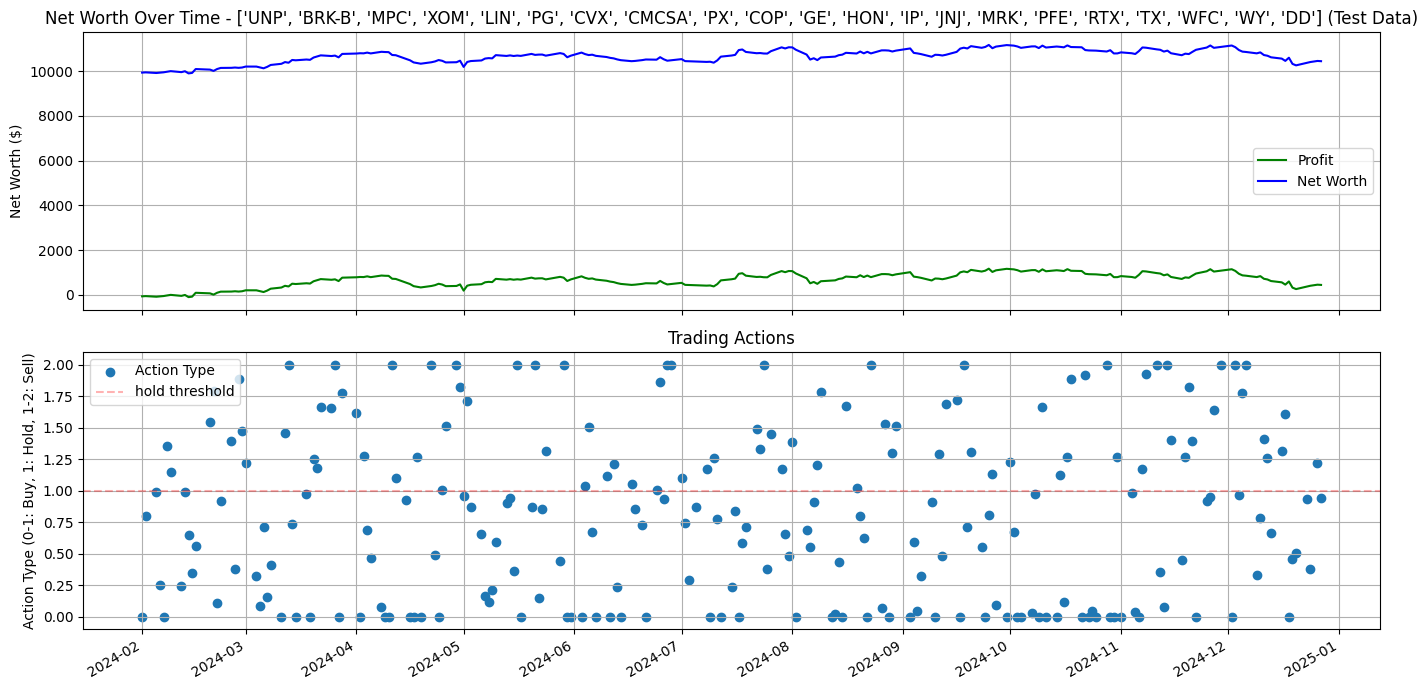

In [5]:
# Load saved environment and set to test mode
test_env_path = f"../models/env_{MODEL.__name__}_portfolio_lexcx.pkl"
model_path = f'../models/{MODEL.__name__}_{tickers}.zip'
model,test_env = load_test_model_env(MODEL,POLICY,test_env_path,model_path)

# Evaluate the model
net_worths, rewards, actions, dates = evaluate_model(model, test_env)
    
# Plot net worth over time with dates
if net_worths[-1] == config.INITIAL_BALANCE:
    net_worths.pop(-1)
    actions.pop(-1)
    dates.pop(-1)
    rewards.pop(-1)
# Convert dates to proper datetime objects for plotting
dates = pd.to_datetime(dates)

# Plot net worth over time with dates
plot_one_instance(net_worths=net_worths, actions=actions, dates=dates, ticker=tickers)

## Performance Analysis

- **Final portfolio return** (percentage gain/loss over the test period)
- **Maximum drawdown** (largest observed loss from a peak to a trough)
- **Equal-weighted buy & hold return** (average return if each stock was held with equal weight)
- **RL Model vs Buy & Hold** (difference in performance between the RL agent and the buy & hold strategy)

It also displays the number of data points used for training and testing for each stock in the portfolio.

In [6]:
# Analyze model performance for the portfolio
final_return = (net_worths[-1] - test_env.envs[0].initial_balance) / test_env.envs[0].initial_balance * 100
max_drawdown = ((np.maximum.accumulate(net_worths) - net_worths) / np.maximum.accumulate(net_worths)).max() * 100

print(f"Final Portfolio Return: {final_return:.2f}%")
print(f"Max Drawdown: {max_drawdown:.2f}%")

# Compare with buy and hold strategy (equal-weighted portfolio)
test_start_date = dates[0]
test_end_date = dates[-1]
print(f"Test period: {test_start_date.strftime('%Y-%m-%d')} to {test_end_date.strftime('%Y-%m-%d')}")

buy_hold_returns = []
for ticker in tickers:
    first_price = test_env.envs[0].test_data[ticker].iloc[0]['Close']
    last_price = test_env.envs[0].test_data[ticker].iloc[-1]['Close']
    buy_hold_return = (last_price - first_price) / first_price * 100
    buy_hold_returns.append(buy_hold_return)

# Equal-weighted average buy & hold return
portfolio_buy_hold_return = np.mean(buy_hold_returns)
print(f"Equal-Weighted Buy & Hold Return: {portfolio_buy_hold_return:.2f}%")
print(f"RL Model vs Buy & Hold: {final_return - portfolio_buy_hold_return:.2f}%")

# Display mode information
# for ticker in tickers:
#     print(f"{ticker}: Training data points = {len(test_env.envs[0].train_data[ticker])}, Testing data points = {len(test_env.envs[0].test_data[ticker])}")

Final Portfolio Return: 4.47%
Max Drawdown: 8.17%
Test period: 2024-02-01 to 2024-12-27
Equal-Weighted Buy & Hold Return: 9.07%
RL Model vs Buy & Hold: -4.60%


# Evaluation & Plots over multiple episode

In [7]:
# --- Evaluate with 100 episodes ---
test_env_path = f"../models/env_{MODEL.__name__}_portfolio_lexcx.pkl"
model_path = f'../models/{MODEL.__name__}_{tickers}.zip'
model,test_env = load_test_model_env(MODEL,POLICY,test_env_path,model_path)

net_worths_array = []
# evaluate the model over 100 episodes
episodes = 100
for episode in range(1, episodes + 1):
    net_worths , _r, _a, _d = evaluate_model(model, test_env)
    del _r , _a , _d
    if net_worths[-1] == config.INITIAL_BALANCE:
        net_worths.pop(-1)
    net_worths_array.append(net_worths[-1])
    if episode % 5 == 0:
        print(f"episode:\t{episode}/{episodes}\tAvg Net worth:\t{np.mean(net_worths):.2f}\tFinal Net worth:\t{net_worths[-1]:.2f}")
    if episode == episodes:
        print("Evalution finished")
        print(f"Avg Net Worth: {np.mean(net_worths_array):.2f}")

# save the results
results = {
    'net_worths': net_worths_array
}
results_df = pd.DataFrame(results)
results_df.to_csv(f"../results/{MODEL.__name__}_protfolio_lexcx_{episodes}_results.csv", index=False)    

Data split complete for 21 stocks
Data aligned to 400 common trading days
Data aligned to 251 common trading days
Environment set to test mode with 251 data points
episode:	5/100	Avg Net worth:	10718.54	Final Net worth:	10668.88
episode:	10/100	Avg Net worth:	10334.38	Final Net worth:	9862.39
episode:	15/100	Avg Net worth:	10331.17	Final Net worth:	10045.14
episode:	20/100	Avg Net worth:	10766.87	Final Net worth:	10384.68
episode:	25/100	Avg Net worth:	10666.85	Final Net worth:	10378.87
episode:	30/100	Avg Net worth:	10590.79	Final Net worth:	10057.53
episode:	35/100	Avg Net worth:	10372.06	Final Net worth:	10322.32
episode:	40/100	Avg Net worth:	10648.52	Final Net worth:	10610.61
episode:	45/100	Avg Net worth:	10175.29	Final Net worth:	9899.98
episode:	50/100	Avg Net worth:	10745.71	Final Net worth:	10672.91
episode:	55/100	Avg Net worth:	10592.26	Final Net worth:	10214.17
episode:	60/100	Avg Net worth:	11036.72	Final Net worth:	11004.28
episode:	65/100	Avg Net worth:	10854.93	Final N

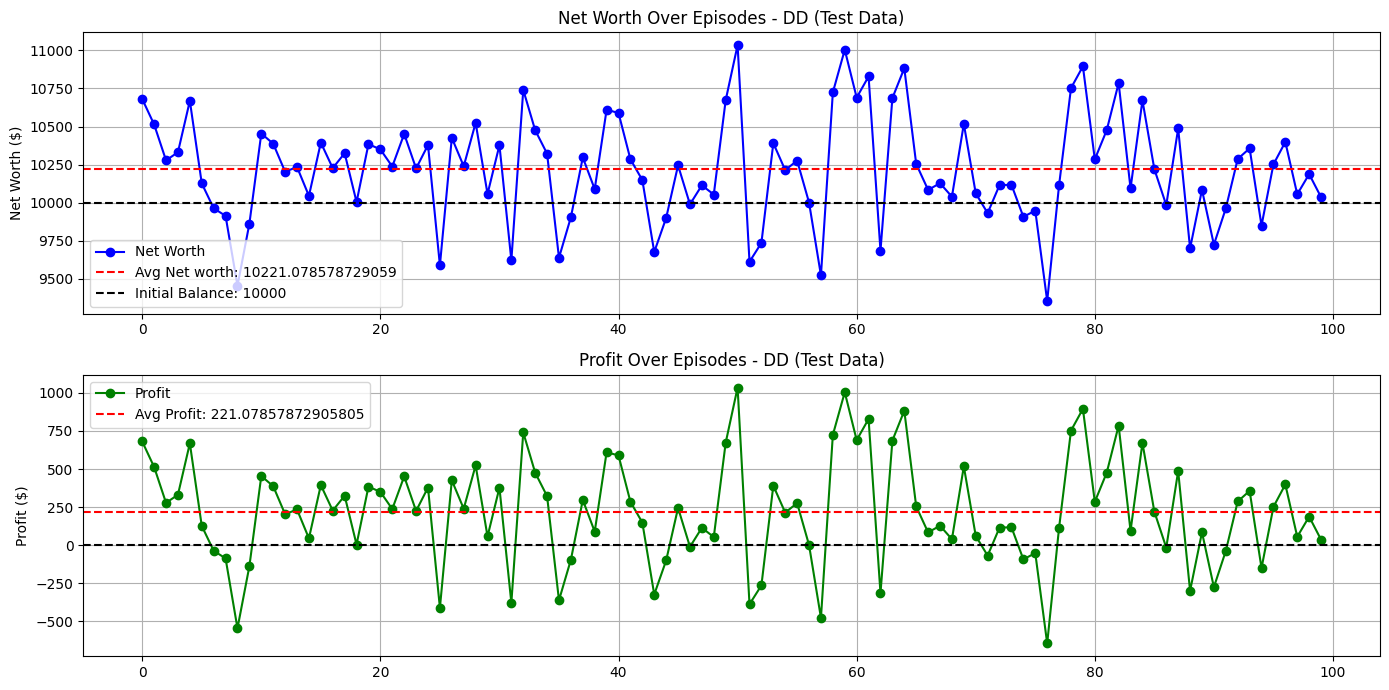

Maximum Net Worth:	11034.42	Maximum Profit: 1034.42
Minimum Net Worth:	9355.19	Minimum Profit: -644.81


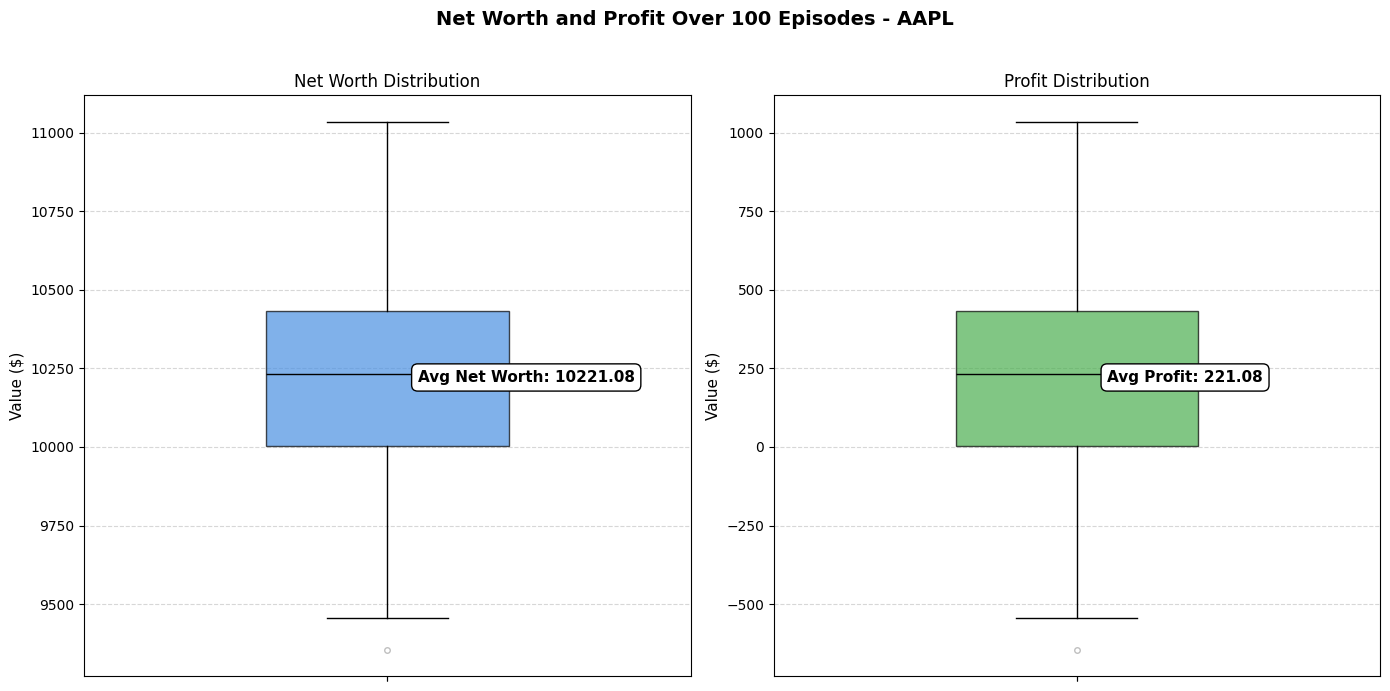

In [8]:
episodes = 100
# load the results
results_df = pd.read_csv(f"../results/{MODEL.__name__}_protfolio_lexcx_{episodes}_results.csv")
# Extract each column as a array
net_worths = np.array(results_df['net_worths'].values)
profit = np.array(net_worths) - np.array([config.INITIAL_BALANCE]*len(net_worths)) 
# Net Worth and Profit Over Episodes With Sentiment Analysis
plot_networths_profit(net_worths, profit, ticker)